# AP3 - Analyses d'oscillations et de potentiels évoqués

Ce tutoriel sont inspirés de [ceux de Dr. Jas](https://jasmainak.github.io/mne-workshop-brown/readme.html), n'hésitez pas à aller les consulter pour aller plus loin. Les tutoriels disponibles dans la [documentation de MNE-Python](https://mne.tools/stable/auto_tutorials/index.html) sont aussi une excellente ressource.

## Introduction de l'activité

Au cours de cette activité, nous allons reprendre les données nettoyées lors de l'AP2 afin de les analyser, c'est à dire créer des visualisation et calculer des "attributs" (*features*) du signal permettant de le décrire et de comparer les conditions. Certains de ces attributs seront par la suite ré-utilisés lors de l'AP4 afin de faire une classification par apprentissage machine qui permettra de réaliser des tests d'hypothèses sur les données, et donc de décider si les résultats sont "statistiquement significatifs" ou non.

Dans cette activité nous allons voir comment :
- Segmenter nos données pour obtenir des *epochs* à partir du signal continu (brute, ou *raw*).
- Moyenner ces *epochs* pour obtenir des réponses évoquées.
- Calculer des densités spectrales de puissance (PSD), c'est à dire quantifier les oscillations.
- Calculer des cartes temps-fréquence pour explorer le décours temporel des oscillations.

Commençons, comme d'habitude, par quelques imports et par le chargement des données. Ici, nous chargeons les données nettoyées sauvegardées lors de l'AP2, il faudra donc rouler le précédent notebook avant celui-ci pour que ça fonctionne.

In [1]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = mne.datasets.sample.data_path()
raw = mne.io.read_raw_fif(os.path.join(data_path, 'MEG', 'sample', 'sample_audvis_clean.fif'))

Opening raw data file /Users/hamzaabdelhedi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_clean.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


/var/folders/dy/yqsbvh6j7r7gz1ktnr8gx4g80000gn/T/ipykernel_15851/2012461321.py:2: RuntimeWarning: This filename (/Users/hamzaabdelhedi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(os.path.join(data_path, 'MEG', 'sample', 'sample_audvis_clean.fif'))


## Segmentation
Lors d'une collecte M/EEG, il est courant d'associer le signal à des évènements en lien avec la tâche. Par exemple, dans le dataset que nous utilisons ici, les données ont été collectées pendant une expérience audio-visuelle au cours de laquelle des stimuli ont été présentés tantôt dans le champ visuel droit ('visual/right') tantôt dans le champ visuel gauche ('visual/left'). Si l'on s'intéresse au traîtement visuel de ces stimuli, il serait donc pertinent de découper le signal en plus petites portions qui correspondent aux moments où un stimulus a été présenté.  
  
Cette information est généralement encodée dans un canal supplémentaire par une valeur, typiquement en 8bit (donc entre 0 et 256). Pour chaque point du temps, ce canal a donc une valeur qui décrit la présence ou l'absence d'un évènement pertinent à l'expérience.  
  
MNE-Python permet d'extraire facilement ces évènements grace à la fonction [mne.find_events()](https://mne.tools/stable/generated/mne.find_events.html?highlight=mne%20find_events#mne.find_events).

In [3]:
events = mne.find_events(raw, stim_channel='STI 014') # Nos évènements sont encodés dans le canal nommé "STI 014"
print(events[:5]) # Affichons les 5 premiers évènements

320 events found
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


Dans l'array ci-dessus, la première colonne correspond au moment (en nombre de *timepoints*) de l'événement et la troisième colonne permet d'identifier de quel événement il s'agit.

On peut utiliser une fonction *built-in* (= fournie avec MNE-Python) pour visualiser sommairement la répartition de ces événements :

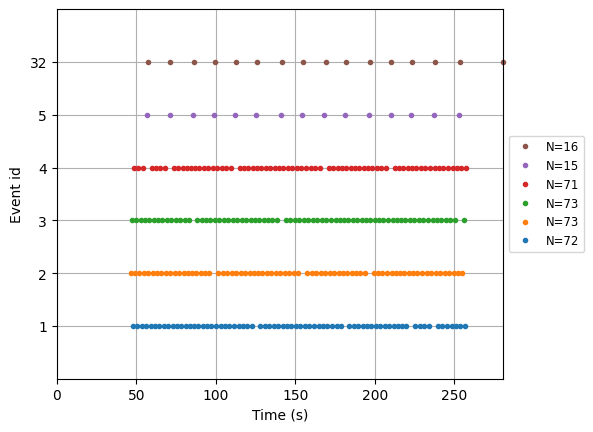

In [4]:
mne.viz.plot_events(events, sfreq=raw.info['sfreq']);

Maintenant, on peut utiliser ce vecteur d'évènements pour segmenter les données, mais avant ça il faut définir quelques paramètres :
  
Premièrement, le nom des conditions. Dans ce dataset, des stimuli auditifs ou visuels ont été présentés soit à gauche, soit à droite. Nous allons commencer par visualiser les réponses évoquées de l'expérience auditive, puis nous analyserons les oscillations induites par l'expérience visuelle, qui serviront aussi de base à la classification de l'AP4.

In [5]:
event_id = {"auditory/left": 1,
            "auditory/right": 2,
            "visual/left": 3,
            "visual/right": 4}

Ensuite, on indique les bornes de nos segments, en secondes. Pour l'exemple, on découpera le signal de 200ms avant l'évènement à 500ms après, pour faire des segments d'une longueur totale de 700ms.

In [6]:
tmin, tmax = -0.2, 0.5

Enfin, il est souvent important de "normaliser" le signal par la ligne de base, afin qu'il soit correctement centré sur 0 et puisse être comparé d'un essai à l'autre. Sinon, l'activité de fond (*background activity*) va s'ajouter à l'activité évoquée, ce qui va rendre sa visualisation moins précise. Cette activité de fond est l'activité cérébrale en l'**absence** du stimulus, et ce qui nous intéresse est l'activité cérébrale **provoquée par** le stimulus.  
On peut donc partir du principe que l'activité cérébrale **après l'apparition** du stimulus est constituée de :
l'activité cérébrale en l'**absence** du stimulus + l'activité cérébrale **provoquée par** le stimulus.
$$S_{post} = S_{pre} + S_{stim} $$
  
Ainsi, il est pertinent de soustraire l'activité cérébrale en l'**absence** du stimulus à l'activité cérébrale **après l'apparition** du stimulus pour obtenir l'activité cérébrale **provoquée par** le stimulus.

$$S_{stim} = S_{post} - S_{pre}$$

Les bornes de notre baseline correspondent donc typiquement à la période pré-stimulus de nos *epochs*, c'est à dire -200 à 0ms. Ici, la valeur 'None' signifie 'dès le début', ce qui correspond à -200ms. La normalisation elle-même sera réalisée par la fonction mne.Epochs()

In [7]:
baseline = (None, 0)

On peut maintenant passer tous ces arguments à la fonction mne.Epochs() pour procéder à la segmentation. 

In [8]:
picks = mne.pick_types(raw.info, meg=True, eeg=False)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=None,                   
                    preload=True)
epochs

Not setting metadata
289 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 289 events and 421 original time points ...
0 bad epochs dropped


Number of events,289
Events,auditory/left: 72auditory/right: 73visual/left: 73visual/right: 71
Time range,-0.200 – 0.499 s
Baseline,-0.200 – 0.000 s


La méthode epochs.plot_image() est très pratique lorsqu'il s'agit de visualiser des epochs. Elle combine la visualisation des epochs individuelles (dans le graphique du haut, chaque ligne représente une epoch) avec la visualisation d'un potentiel évoqué (le graphique du bas). Utilisons-la pour visualiser les epochs sur un capteur occipital (donc au-dessus des aires visuelles).

Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated


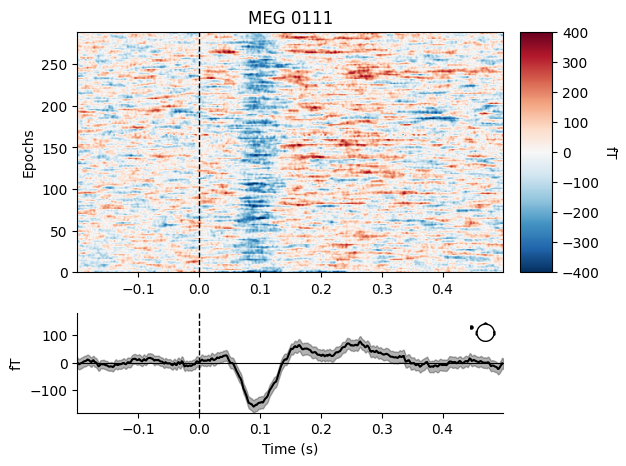

In [9]:
epochs.plot_image(picks=2, cmap='interactive', sigma=1., vmin=-400, vmax=400);

In [ ]:
# Question 1: reproduire le même graphique avec les données d'autre électrodes en changeant la valeur de l'argument picks.
ADD CODE HERE



## Potentiels évoqués
Visualiser le potentiel évoqué est un bon début, mais l'avantage des réponses évoquées c'est surtout la possibilité de déterminer une amplitude et un moment pour laquelle cette réponse est maximale. On appelle ça le "pic" et la "latence" du potentiel évoqué. Pour mesurer ces valeurs facilement, nous allons utiliser l'objet mne.Evoked, qui est créé en moyennant les epochs, c'est à dire en appelant la méthode [epochs.average()](https://mne.tools/stable/generated/mne.Epochs.html?highlight=epochs%20average#mne.Epochs.average).

In [10]:
evokeds = [epochs[name].pick_types(meg='grad').average() for name in ('auditory/left', 'auditory/right')]
evokeds

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[<Evoked | 'auditory/left' (average, N=72), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 203 ch, ~3.7 MB>,
 <Evoked | 'auditory/right' (average, N=73), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 203 ch, ~3.7 MB>]

Visualisons la réponse évoquée dans les deux conditions, **left** et **right**.

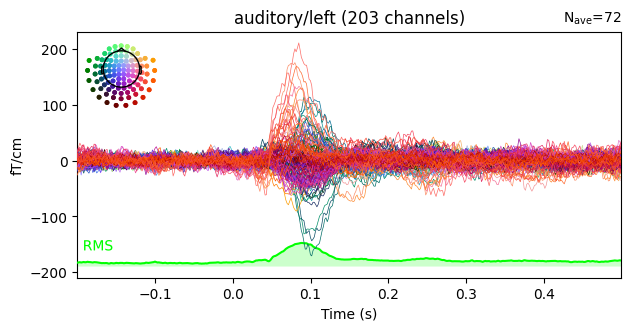

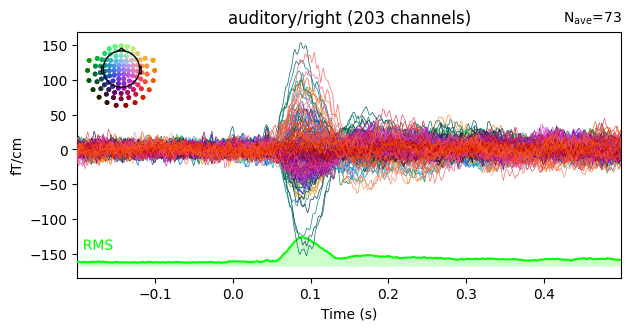

In [11]:
for evoked in evokeds:
    evoked.plot(gfp=True, titles=evoked.comment);

Malheureusement, cette représentation n'est pas très informative quant à la répartition spatiale de cette activité. Pour cela, il est préférable d'utiliser la méthode [evoked.plot_topomap()](https://mne.tools/stable/generated/mne.Evoked.html?highlight=evoked%20plot_topomap#mne.Evoked.plot_topomap).

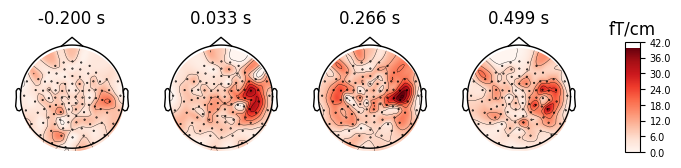

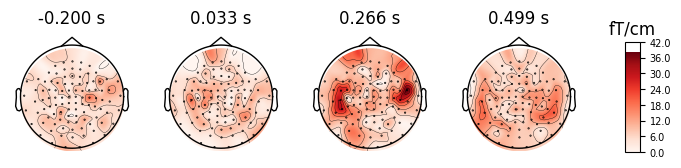

In [12]:
for evoked in evokeds:
    evoked.plot_topomap(
        sphere=0.18,
        extrapolate='head',
    );

Encore mieux ! La méthode [evoked.plot_joint()](https://mne.tools/stable/generated/mne.Evoked.html?highlight=evoked%20plot_joint#mne.Evoked.plot_joint) permet de combiner les deux approches ci-dessus.

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


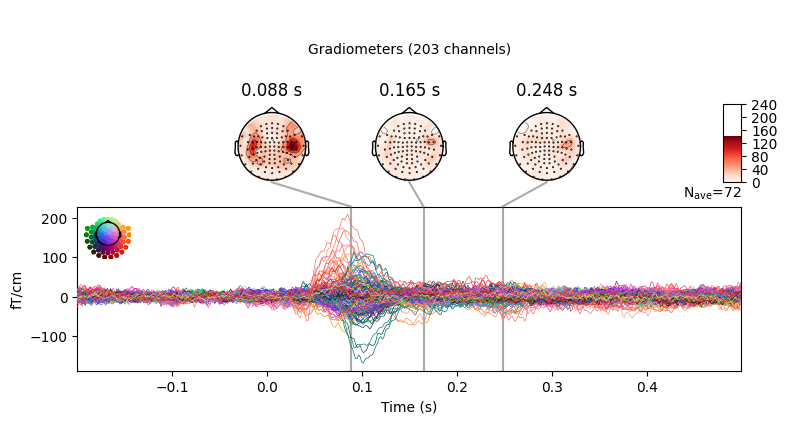

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


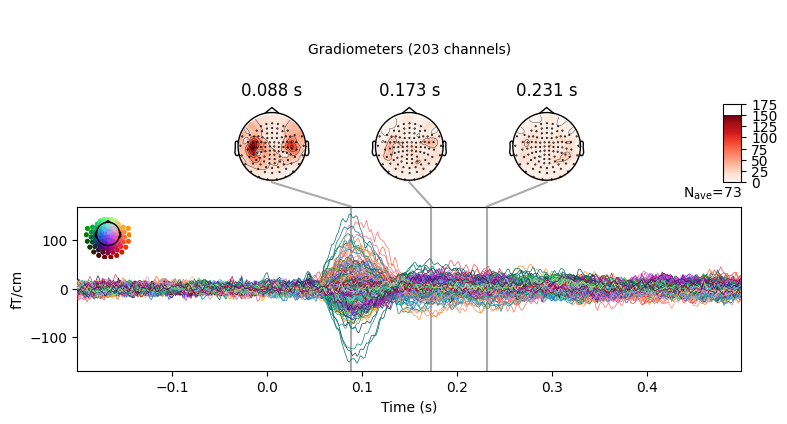

In [13]:
for evoked in evokeds:
    evoked.plot_joint(
        topomap_args=dict(
        sphere=0.18,
        extrapolate='head',)
    );

On peut aussi très facilement calculer des *ondes de différence* en soustrayant un potentiel évoqué à un autre afin de faire ressortir la différence entre les deux. Pour cela, on utilise la fonction [mne.combine_evoked()](https://mne.tools/stable/generated/mne.combine_evoked.html?highlight=mne%20combine_evoked#mne.combine_evoked) et en spécifiant des *poids* inversés. Dans cet exemple, on soustrait le potentiel de droite (le second de la list evokeds) à celui de gauche (le premier).

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


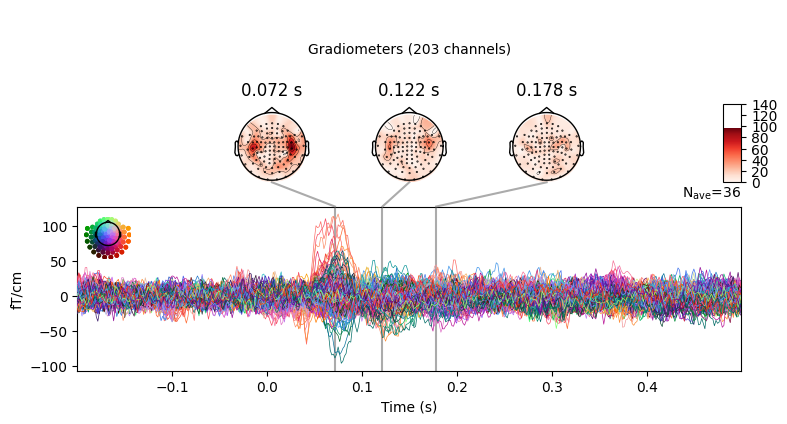

In [14]:
evoked_diff = mne.combine_evoked(evokeds, weights=[1,-1])
evoked_diff.plot_joint(
        topomap_args=dict(
        sphere=0.18,
        extrapolate='head',)
);

Enfin, nous sommes prêts à estimer la latence et l'amplitude de nos pics de potentiels évoqués. Pour cela, on utilise la méthode [evoked.get_peak()](https://mne.tools/stable/generated/mne.Evoked.html?highlight=evoked%20get_peak#mne.Evoked.get_peak) :

Onde de différence : pic détecté sur MEG 1323, à une latence de 0.07492320493439544s, avec une amplitude de 1.1777873351771988e-11fT/cm
Stimulus à gauche : pic détecté sur MEG 1332, à une latence de 0.08491296559231484s, avec une amplitude de 2.1116722821962584e-11fT/cm
Stimulus à droite : pic détecté sur MEG 0242, à une latence de 0.0882428858116213s, avec une amplitude de 1.5329124510140813e-11fT/cm


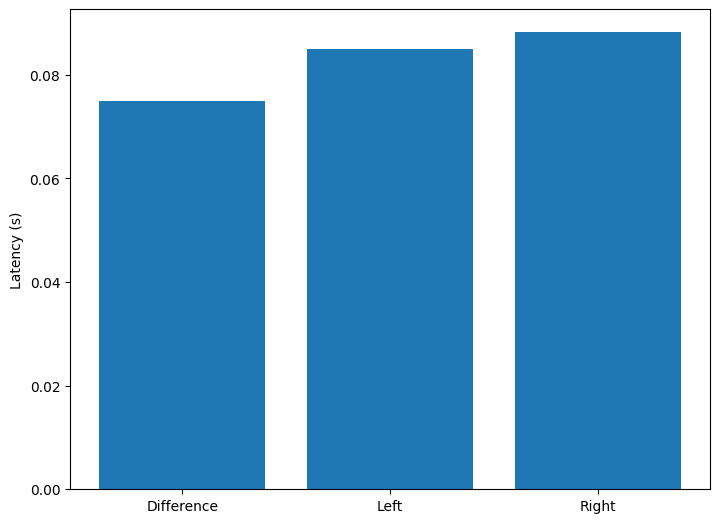

In [15]:
diff_peak = evoked_diff.get_peak(return_amplitude=True)
left_peak = evokeds[0].get_peak(return_amplitude=True)
right_peak = evokeds[1].get_peak(return_amplitude=True)
print(f'Onde de différence : pic détecté sur {diff_peak[0]}, à une latence de {diff_peak[1]}s, avec une amplitude de {diff_peak[2]}fT/cm')
print(f'Stimulus à gauche : pic détecté sur {left_peak[0]}, à une latence de {left_peak[1]}s, avec une amplitude de {left_peak[2]}fT/cm')
print(f'Stimulus à droite : pic détecté sur {right_peak[0]}, à une latence de {right_peak[1]}s, avec une amplitude de {right_peak[2]}fT/cm')

# Tracer un simple graphique pour visualiser les latences :
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
condition = ['Difference', 'Left', 'Right']
latency = [diff_peak[1], left_peak[1], right_peak[1]]
ax.bar(condition,latency)
ax.set_ylabel('Latency (s)')
plt.show()

Ici, on peut donc voir que la latence du pic est comparable pour les conditions 'Left' et 'Right'. En revanche, la latence du pic de l'onde de différence est légèrement plus courte. Cela signifie que la différence entre 'Left' et 'Right' atteint son maximum **avant** que le PE de 'Left' et de 'Right' n'atteigne son pic. C'est ce type d'effet que l'on cherche généralement à interpréter lors d'une étude de potentiel évoqué.

Puisque les potentiels évoqués sont couramment découpés en composantes, il est aussi possible de détecter le pic dans une fenêtre temporelle précise. Par exemple, si l'on s'intéresse à la partie plus tardive de la réponse, on peut procéder ainsi :

In [16]:
diff_peak = evoked_diff.get_peak(return_amplitude=True, tmin=0.15)
left_peak = evokeds[0].get_peak(return_amplitude=True, tmin=0.15)
right_peak = evokeds[1].get_peak(return_amplitude=True, tmin=0.15)
print(f'Onde de différence : pic détecté sur {diff_peak[0]}, à une latence de {diff_peak[1]}s, avec une amplitude de {diff_peak[2]}fT/cm')
print(f'Stimulus à gauche : pic détecté sur {left_peak[0]}, à une latence de {left_peak[1]}s, avec une amplitude de {left_peak[2]}fT/cm')
print(f'Stimulus à droite : pic détecté sur {right_peak[0]}, à une latence de {right_peak[1]}s, avec une amplitude de {right_peak[2]}fT/cm')


Onde de différence : pic détecté sur MEG 1333, à une latence de 0.1964652929390814s, avec une amplitude de 5.211841257176386e-12fT/cm
Stimulus à gauche : pic détecté sur MEG 1443, à une latence de 0.1548412901977506s, avec une amplitude de -7.351067449040126e-12fT/cm
Stimulus à droite : pic détecté sur MEG 1443, à une latence de 0.1598361705267103s, avec une amplitude de -6.320674885146547e-12fT/cm


## Oscillations : Power Spectrum Density (PSD)
Une autre approche courante en électrophysiologie consiste à étudier l'activité rythmique du cerveau en quantifiant les oscillations cérébrales présentes dans le signal. Cela implique d'obtenir une représentation fréquentielle du signal, appelée un [spectre](https://en.wikipedia.org/wiki/Spectral_density#Explanation). 

Un moyen facile et rapide de visualiser le spectre du signal est d'utiliser la méthode [.plot_psd()](https://mne.tools/stable/generated/mne.Epochs.html?highlight=plot_psd#mne.Epochs.plot_psd). Lorsqu'elle est appliquée à un objet Epochs, cette méthode calcule le spectre pour chaque epoch, puis les moyenne. Les bandes grises sur le graphique ci-dessous représentent l'écart-type, tandis que la ligne droite représente la puissance moyennée à travers les epochs."

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/opt/homebrew/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


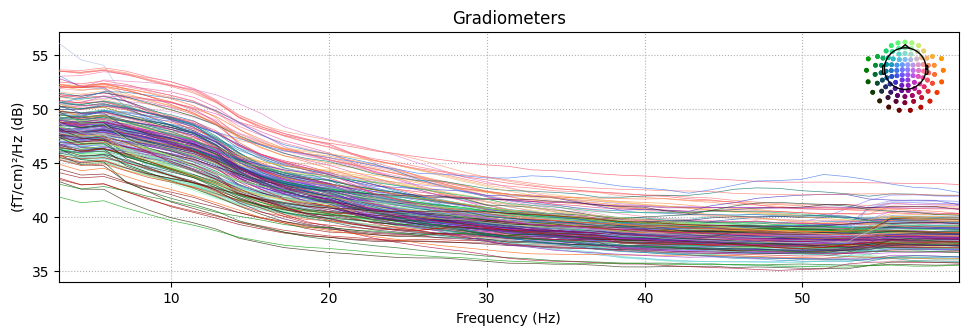

In [17]:
epochs.compute_psd(fmin=2., fmax=60., picks='grad').plot();

In [ ]:
# Question 2: reproduire le même graphique avec les données d'autre électrodes en changeant la valeur de l'argument picks.
ADD CODE HERE

Cette représentation nous renseigne sur la puissance de chaque fréquence présente dans le signal. Cependant, l'intérêt principal réside souvent dans la puissance moyenne à travers des bandes spécifiques telles que delta, theta, alpha, beta, gamma, etc.

Ici, nous allons calculer les densités spectrales de puissance (PSD) dans les bandes theta (4 à 8 Hz), alpha (8 à 12 Hz), beta (12 à 30 Hz) et gamma (30 à 60 Hz). Ensuite, nous allons moyenne les différentes *bins*, c'est-à-dire les puissances associées aux fréquences situées entre les bornes (nous allons donc moyenner les puissances entre 4 et 8 Hz pour theta, par exemple).

Dans cette cellule, nous allons également sauvegarder ces valeurs de PSD moyennées, car elles seront utilisées pour la classification de l'AP4.

In [18]:
freq_bands = [[4,8],[8,12],[12,30],[30,60]]
conditions = ['visual/left', 'visual/right']

# On initialise un dict pour stocker les valeurs
psds_dict = {'visual/left':[],
                 'visual/right':[]}
# Dans cette boucle, on calcule les PSD, on les moyenne par bande puis on les stock
for condition in conditions:
    psds_allbands = []
    for band in freq_bands:
        epochs_to_classify = epochs[condition].copy().pick_types(meg='planar1', verbose=False)
        psds, freqs = epochs_to_classify.compute_psd(
                                                    tmin=0, tmax=0.5, 
                                                    fmin=band[0], fmax=band[1], 
                                                    n_jobs=1).get_data(return_freqs = True)
        psds = 10 * np.log10(psds)  # convert to dB
        psds_band = np.mean(psds, axis=2)
        psds_allbands.append(psds_band)
    psds_allbands = np.array(psds_allbands).T
    psds_dict[condition] = psds_allbands
    
    # Ces deux lignes servent à sauvegarder un fichier par condition
    condition = ''.join(condition.split('/'))
    np.save(os.path.join(data_path, 'MEG', 'sample', f'{condition}_psds_bands'), psds_allbands)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


Pour visualiser les densités spectrales de puissance (PSD), il est possible de créer un contraste entre deux conditions. Une approche pertinente dans ce contexte est d'exprimer les valeurs en pourcentage de changement d'une condition par rapport à l'autre. Par exemple, en utilisant la formule suivante : $$\frac{Left - Right}{Right}$$
  
on exprime les valeurs de la condition 'Left' comme un changement en pourcentage par rapport aux valeurs de la condition 'Right'. Cette méthode permet de mettre en évidence les différences relatives entre les deux conditions de manière significative.

In [19]:
alpha_left = np.average(psds_dict['visual/left'][:,:,1], axis=1)
alpha_right = np.average(psds_dict['visual/right'][:,:,1], axis=1)
alpha_contrast = (alpha_left - alpha_right) / (alpha_right)

Enfin, pour visualiser ces données de manière topographique, il est possible d'utiliser la fonction [mne.viz.plot_topomap()](https://mne.tools/stable/generated/mne.viz.plot_topomap.html?highlight=plot_topomap).

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


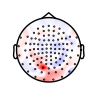

In [20]:
info = raw.copy().pick_types(meg='mag').info
mne.viz.plot_topomap(alpha_contrast, info, cmap='bwr', sphere=0.18, extrapolate='head', contours=0);

In [52]:
# Question 3: reproduire le même graphique avec les données d'autre électrodes en changeant la valeur de l'argument picks. 
# A la place de planar 1 utiliser planar 2. Ce sont les types de capteurs gradiomètres.
# Attentionm il faut aussi engregistrer les données dans un fichier différent.

## Cartes temps-fréquence
On peut visualiser les données simultanément dans les domaines temporels et fréquentiels grâce à une carte temps-fréquence. Cela signifie que l'on trace les variations de puissance oscillatoire dans le temps. Pour ce faire, la fonction [mne.time_frequency.tfr_multitaper()](https://mne.tools/stable/generated/mne.time_frequency.tfr_multitaper.html?highlight=tfr_multitaper#mne.time_frequency.tfr_multitaper) permet d'estimer la puissance à différents moments du temps.

In [21]:
# Il faut construire manuellement l'espace de fréquence à passer à la fonction tfr_multitaper.
freqs = np.logspace(*np.log10([4, 60]), num=8)
n_cycles = freqs / 2.

power, itc = mne.time_frequency.tfr_multitaper(epochs['visual/left'], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)
power

<AverageTFR | time : [-0.199795, 0.499488], freq : [4.000000, 60.000000], nave : 73, channels : 305, ~5.8 MB>

Le résultat de cette opération est un objet de type [mne.AverageTFR](https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html?highlight=average%20tfr#mne.time_frequency.AverageTFR). Comme d'habitude, cet objet offre des méthodes facilitant la visualisation des données.

Par exemple, il est possible d'afficher la carte temps-fréquence d'un capteur en particulier. Au hasard, disons le capteur 82. 

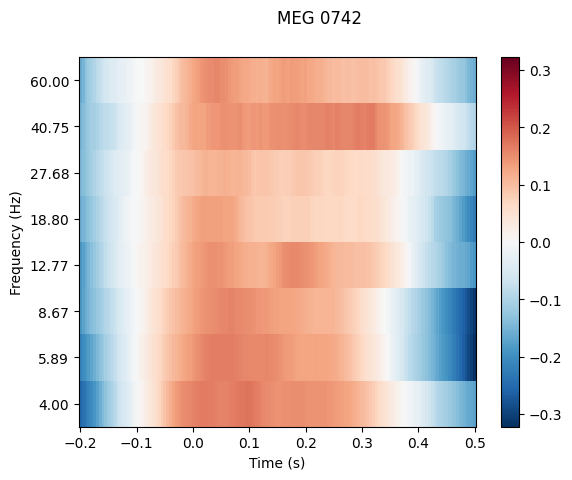

[<Figure size 640x480 with 2 Axes>]

In [22]:
power.plot([82], baseline=(-0.2, 0), mode='logratio', title=power.ch_names[82], verbose=False)

In [ ]:
# Question 4: reproduire le même graphique avec des differentes valeurs de capteur.
ADD CODE HERE

Encore une fois, on peut utiliser la méthode `.plot_topomap()` pour obtenir un résultat similaire à la topographie obtenue lors du calcul des PSD. Dans ces topographies, la dimension temporelle a été moyennée, permettant ainsi d'observer la puissance Alpha ou Beta moyennée à travers le temps et les essais.

Applying baseline correction (mode: logratio)


Applying baseline correction (mode: logratio)


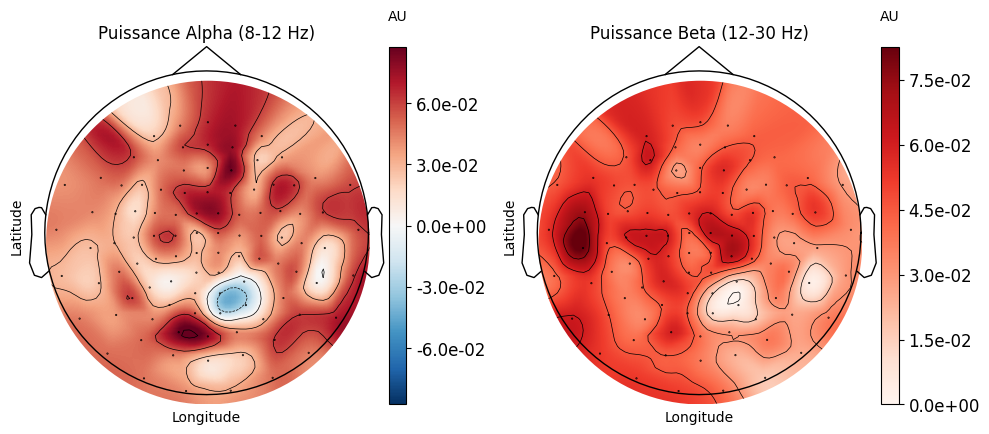

In [23]:
# Création de la figure et des axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Subplot 1 : Topographie de la puissance Alpha (8-12 Hz)
axes[0].set_title("Puissance Alpha (8-12 Hz)")
power.plot_topomap(ch_type='grad', tmin=-0.2, tmax=0.5, fmin=8, fmax=12,
                   baseline=(-0.2, 0), mode='logratio', axes=axes[0], sphere=0.18, extrapolate='head',
                   show=False)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Subplot 2 : Topographie de la puissance Beta (12-30 Hz)
axes[1].set_title("Puissance Beta (12-30 Hz)")
power.plot_topomap(ch_type='grad', tmin=-0.2, tmax=0.5, fmin=12, fmax=30,
                   baseline=(-0.5, 0), mode='logratio', axes=axes[1], sphere=0.18, extrapolate='head',
                   show=False)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Réglage de l'espacement entre les sous-plots
plt.tight_layout()

# Affichage de la figure
plt.show()

Enfin, les *joint plots* sont également disponibles et offrent une exploration plus complète des cartes en y ajoutant des topomaps aux moments d'intérêt.

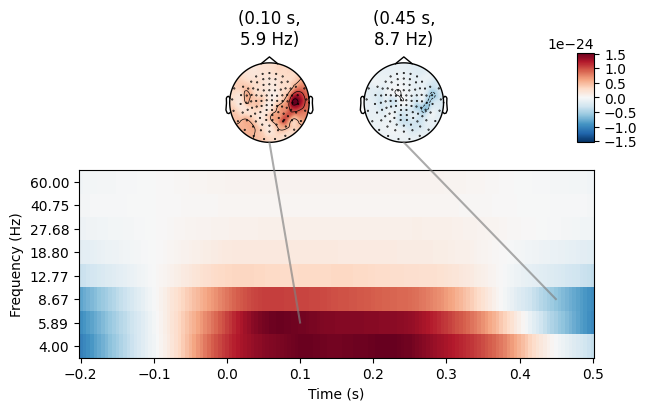

In [24]:
# Utilisation de la méthode plot_joint pour explorer les cartes avec des topomaps aux moments d'intérêt
power.plot_joint(baseline=(-0.2, 0), mode='mean', tmin=-.2, tmax=0.5,
                 timefreqs=[(.1, 5), (0.450, 10)], verbose=False, picks='mag',
                 topomap_args=dict(sphere=0.18, extrapolate='head'));
# Paramètres utilisés dans la méthode plot_joint :
# - baseline spécifie la période de référence pour la puissance relative
# - mode indique le type de représentation, ici 'mean' pour la moyenne
# - tmin et tmax définissent les limites temporelles de l'exploration
# - timefreqs spécifie les plages de temps et de fréquence où les topomaps sont ajoutés
# - verbose=False pour supprimer les messages de débogage
# - picks='mag' sélectionne les capteurs MEG de type 'mag'
# - topomap_args spécifie les paramètres des topomaps

In [ ]:
# Question 5: reproduire les deux graphiques avec des differentes fréquences.
ADD CODE HERE

In [ ]:
# Question 6: Optionel, Faire les memes graphiques avec les données planar2.  
ADD CODE HERE

In [ ]:
# Question 7: Optionel, Calculer le PSD pour d'autre conditions et comparer les résultats. Exp: Visual/Left vs Visual/Right
ADD CODE HERE

## Conclusion
Nous avons maintenant généré des PSDs qui sont enregistrées dans des fichiers. Vous pouvez les charger et les utiliser pour des analyses ultérieures. Une fois que vous avez confirmé la qualité de ces données, elles peuvent être utilisées comme caractéristiques (features) dans des modèles d'apprentissage automatique pour des analyses plus avancées et des prédictions précises. C'est ce qu'on va faire dans la prochaine partie.

In [25]:
# FIN